# NetCDF

A very efficient way to read, analyze and write NetCDF files is to use the [xarray](http://xarray.pydata.org/en/stable/) Python library, which can be viewed as a ND counterpart of the [pandas](http://pandas.pydata.org). 

## Reading NetCDF

### Reading single file

Reading NetCDF files is dones by using the `xarray.open_dataset` method, which returns a [xarray.Dataset](http://xarray.pydata.org/en/stable/data-structures.html#dataset) object.

In [1]:
import xarray as xr
import numpy as np

data = xr.open_dataset('data/UV500storm.nc')
data

<xarray.Dataset>
Dimensions:   (lat: 33, lon: 36, timestep: 1)
Coordinates:
  * lat       (lat) float32 20.0 21.25 22.5 23.75 25.0 ... 56.25 57.5 58.75 60.0
  * lon       (lon) float32 -140.0 -137.5 -135.0 -132.5 ... -57.5 -55.0 -52.5
  * timestep  (timestep) int32 372
Data variables:
    reftime   |S20 ...
    v         (timestep, lat, lon) float32 ...
    u         (timestep, lat, lon) float32 ...
Attributes:
    history:  Thu Jul 21 16:12:12 2016: ncks -A U500storm.nc V500storm.nc\nTh...
    NCO:      4.4.2

### Reading multiple files

Often, a variable is stored in multiple NetCDF files (one file per year for instance). The `xarray.open_mfdataset` allows to open all the files at one and to concatenate them along *record* dimension (`UNLIMITED` dimension, which is usually time) and spatial dimensions.

Below, the four `ISAS13` files are opened at once and are automatically concanated along the record dimension, hence leading to a dataset with 4 time steps.

In [2]:
data = xr.open_mfdataset("data/*ISAS*nc", combine='by_coords')
data

<xarray.Dataset>
Dimensions:  (time: 4, depth: 152)
Coordinates:
  * depth    (depth) float32 0.0 3.0 5.0 10.0 ... 1.96e+03 1.98e+03 2e+03
  * time     (time) datetime64[ns] 2012-01-15 2012-02-15 2012-03-15 2012-04-15
Data variables:
    TEMP     (time, depth) float32 dask.array<chunksize=(1, 152), meta=np.ndarray>
Attributes:
    script:   extract_prof.py
    history:  Thu Jul 14 11:32:10 2016: ncks -O -3 ISAS13_20120115_fld_TEMP.n...
    NCO:      "4.5.5"

Furthermore, complex models are often paralellized using the [Message Passing Interface (MPI)](https://fr.wikipedia.org/wiki/Message_Passing_Interface), in which each processor manages a subdomain. If each processor saves output in its sub-region, there will be as many output files as there are processors.
`xarray` allows to reconstruct the global file by concatenating the subregional files according to their coordinates.

<div class="alert alert-danger">
    <strong>Warning!</strong> This actually works only if the decomposition into subregions is regular, and if subfiles contain coordinates
</div>

In [3]:
data = xr.open_mfdataset("data/GYRE_OOPE*", combine='by_coords', engine='netcdf4')
data['OOPE']

<xarray.DataArray 'OOPE' (time: 10, y: 22, x: 32, community: 3, weight: 100)>
dask.array<concatenate, shape=(10, 22, 32, 3, 100), dtype=float32, chunksize=(10, 11, 16, 3, 100), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) int64 0 1 2 3 4 5 6 7 8 9 10 ... 22 23 24 25 26 27 28 29 30 31
  * y        (y) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21
Dimensions without coordinates: time, community, weight

In the 2 previous examples, `chunksize` variable attribute appeared. This is due to the fact that opening multiple datasets automatically generates `dask` arrays, which are ready for parallel computing. These are discussed in a specific section

### Accessing dimensions, variables, attributes

In [4]:
data = xr.open_dataset("data/UV500storm.nc")
data

<xarray.Dataset>
Dimensions:   (lat: 33, lon: 36, timestep: 1)
Coordinates:
  * lat       (lat) float32 20.0 21.25 22.5 23.75 25.0 ... 56.25 57.5 58.75 60.0
  * lon       (lon) float32 -140.0 -137.5 -135.0 -132.5 ... -57.5 -55.0 -52.5
  * timestep  (timestep) int32 372
Data variables:
    reftime   |S20 ...
    v         (timestep, lat, lon) float32 ...
    u         (timestep, lat, lon) float32 ...
Attributes:
    history:  Thu Jul 21 16:12:12 2016: ncks -A U500storm.nc V500storm.nc\nTh...
    NCO:      4.4.2

#### Dimensions

Recovering dimensions is dony by accessing the `dims` attribute of the dataset, which returns a `dictionary`, the `keys` of which are the dataset dimension names and the values are the number of elements along the dimension.

In [5]:
data.dims

Frozen({'lat': 33, 'lon': 36, 'timestep': 1})

In [6]:
data.dims['lat']

33

#### Variables

Variables can be accessed by using the `data_vars` attribute, which returns a `dictionary`,  the `keys` of which are the dataset variable names.

In [7]:
data.data_vars

Data variables:
    reftime  |S20 b'1996 01 05 00:00'
    v        (timestep, lat, lon) float32 nan nan nan nan ... 54.32 49.82 44.32
    u        (timestep, lat, lon) float32 nan nan nan nan ... 7.713 8.213 9.713

In [8]:
data.data_vars['u']

<xarray.DataArray 'u' (timestep: 1, lat: 33, lon: 36)>
array([[[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [ 0.213205, -0.036795, ..., 10.463205, 10.463205],
        [-2.036795, -1.536795, ...,  8.213205,  9.713205]]], dtype=float32)
Coordinates:
  * lat       (lat) float32 20.0 21.25 22.5 23.75 25.0 ... 56.25 57.5 58.75 60.0
  * lon       (lon) float32 -140.0 -137.5 -135.0 -132.5 ... -57.5 -55.0 -52.5
  * timestep  (timestep) int32 372

Note that data variables can also be accessed by using variable name as the key to the dataset object, as follows:

In [9]:
data['v']

<xarray.DataArray 'v' (timestep: 1, lat: 33, lon: 36)>
array([[[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [-7.183777, -8.183777, ..., 48.816223, 42.316223],
        [-7.683777, -9.683777, ..., 49.816223, 44.316223]]], dtype=float32)
Coordinates:
  * lat       (lat) float32 20.0 21.25 22.5 23.75 25.0 ... 56.25 57.5 58.75 60.0
  * lon       (lon) float32 -140.0 -137.5 -135.0 -132.5 ... -57.5 -55.0 -52.5
  * timestep  (timestep) int32 372

Note that variables are returned as `xarray.DataArray`.

To recover the variable as a `numpy` array, the `values` attribute can be used. In this case, missing values are set to `NaN`.

In [10]:
v = data['v']
v = v.values
v

array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [ -7.183777,  -7.683777,  -8.183777, ...,  53.316223,
          47.816223,  40.816223],
        [ -7.183777,  -8.183777,  -9.183777, ...,  53.816223,
          48.816223,  42.316223],
        [ -7.683777,  -9.683777, -11.683777, ...,  54.316223,
          49.816223,  44.316223]]], dtype=float32)

In order to obtain a masked array instead, use the `to_masked_array()` method:

In [11]:
v = data['v']
v = v.to_masked_array()
v

masked_array(
  data=[[[--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         ...,
         [-7.18377685546875, -7.68377685546875, -8.18377685546875, ...,
          53.31622314453125, 47.81622314453125, 40.81622314453125],
         [-7.18377685546875, -8.18377685546875, -9.18377685546875, ...,
          53.81622314453125, 48.81622314453125, 42.31622314453125],
         [-7.68377685546875, -9.68377685546875, -11.68377685546875, ...,
          54.31622314453125, 49.81622314453125, 44.31622314453125]]],
  mask=[[[ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]],
  fill_value=1e+20,
  dtype=float32)

#### Time management

By default, the time variable is detected by `xarray` by using the NetCDF attributes, and is converted into a human time. This is done by xarray by using the [cftime](https://pypi.org/project/cftime/) module

In [12]:
data = xr.open_mfdataset("data/*ISAS*", combine='by_coords')
data['time']

<xarray.DataArray 'time' (time: 4)>
array(['2012-01-15T00:00:00.000000000', '2012-02-15T00:00:00.000000000',
       '2012-03-15T00:00:00.000000000', '2012-04-15T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2012-01-15 2012-02-15 2012-03-15 2012-04-15

Then, the user can access the `year`, `month`, `day`, `hour`, `minute`, `second`, `microsecond`, `nanosecond`, `date`, `time`, `dayofyear`, `weekofyear`, `dayofweek`, `quarter` as follows:

In [13]:
data['time.year']

<xarray.DataArray 'year' (time: 4)>
array([2012, 2012, 2012, 2012])
Coordinates:
  * time     (time) datetime64[ns] 2012-01-15 2012-02-15 2012-03-15 2012-04-15

In [14]:
data['time.month']

<xarray.DataArray 'month' (time: 4)>
array([1, 2, 3, 4])
Coordinates:
  * time     (time) datetime64[ns] 2012-01-15 2012-02-15 2012-03-15 2012-04-15

In [15]:
data['time.day']

<xarray.DataArray 'day' (time: 4)>
array([15, 15, 15, 15])
Coordinates:
  * time     (time) datetime64[ns] 2012-01-15 2012-02-15 2012-03-15 2012-04-15

In [16]:
data['time.dayofyear']

<xarray.DataArray 'dayofyear' (time: 4)>
array([ 15,  46,  75, 106])
Coordinates:
  * time     (time) datetime64[ns] 2012-01-15 2012-02-15 2012-03-15 2012-04-15

<div class="alert alert-info">
    <strong>Warning</strong> Replace <i>time</i> by the name of your time variable (<i>time_counter</i> in NEMO for instance)
</div>

If the user does not want `xarray` to convert time into a human date, set the `decode_times` argument to False.

In [17]:
data = xr.open_mfdataset("data/*ISAS*", combine='by_coords', decode_times=False)
data['time']

<xarray.DataArray 'time' (time: 4)>
array([22659., 22690., 22719., 22750.])
Coordinates:
  * time     (time) float64 2.266e+04 2.269e+04 2.272e+04 2.275e+04
Attributes:
    units:    days since 1950-01-01T00:00:00Z

**In this case, years, months, etc. cannot be extracted**

#### Attributes

To get variable attributes, use the `attrs` attribute, which exists for `xarray.Dataset` (global attributes) and `xarray.DataArray` objects (variable's attributes). It returns a `dictionary` containing the attribute names and values.

In [18]:
data.attrs

{'script': 'extract_prof.py',
 'history': 'Thu Jul 14 11:32:10 2016: ncks -O -3 ISAS13_20120115_fld_TEMP.nc ISAS13_20120115_fld_TEMP.nc',
 'NCO': '"4.5.5"'}

In [19]:
data.attrs['NCO']

'"4.5.5"'

In [20]:
time = data['time']
time.attrs

{'units': 'days since 1950-01-01T00:00:00Z'}

In [21]:
time.attrs['units']

'days since 1950-01-01T00:00:00Z'

## Indexing

As in `pandas`, there is 2 ways to extract part of a dataset. Let's consider the ISAS dataset, which contains 152 vertical levels unevenly from 0 to 2000m. 

In [22]:
data = xr.open_mfdataset('data/*ISAS*', combine='by_coords')
data

<xarray.Dataset>
Dimensions:  (time: 4, depth: 152)
Coordinates:
  * depth    (depth) float32 0.0 3.0 5.0 10.0 ... 1.96e+03 1.98e+03 2e+03
  * time     (time) datetime64[ns] 2012-01-15 2012-02-15 2012-03-15 2012-04-15
Data variables:
    TEMP     (time, depth) float32 dask.array<chunksize=(1, 152), meta=np.ndarray>
Attributes:
    script:   extract_prof.py
    history:  Thu Jul 14 11:32:10 2016: ncks -O -3 ISAS13_20120115_fld_TEMP.n...
    NCO:      "4.5.5"

### Extracting using indexes

To extract the ten first level and the first to time steps, the `isel` method should be used, which can be applied on either `DataSet` or `DataArray`.

<div class='alert alert-info'>
    <strong>Note</strong> It is the xarray counterpart of the Pandas iloc method
</div>        

In [23]:
data.isel(depth=range(10), time=0)

<xarray.Dataset>
Dimensions:  (depth: 10)
Coordinates:
  * depth    (depth) float32 0.0 3.0 5.0 10.0 15.0 20.0 25.0 30.0 35.0 40.0
    time     datetime64[ns] 2012-01-15
Data variables:
    TEMP     (depth) float32 dask.array<chunksize=(10,), meta=np.ndarray>
Attributes:
    script:   extract_prof.py
    history:  Thu Jul 14 11:32:10 2016: ncks -O -3 ISAS13_20120115_fld_TEMP.n...
    NCO:      "4.5.5"

In [24]:
data.isel(time=slice(0, 2), depth=slice(0, 10))

<xarray.Dataset>
Dimensions:  (time: 2, depth: 10)
Coordinates:
  * depth    (depth) float32 0.0 3.0 5.0 10.0 15.0 20.0 25.0 30.0 35.0 40.0
  * time     (time) datetime64[ns] 2012-01-15 2012-02-15
Data variables:
    TEMP     (time, depth) float32 dask.array<chunksize=(1, 10), meta=np.ndarray>
Attributes:
    script:   extract_prof.py
    history:  Thu Jul 14 11:32:10 2016: ncks -O -3 ISAS13_20120115_fld_TEMP.n...
    NCO:      "4.5.5"

In [25]:
data['TEMP'].isel(time=slice(0, 2), depth=range(0, 10))

<xarray.DataArray 'TEMP' (time: 2, depth: 10)>
dask.array<getitem, shape=(2, 10), dtype=float32, chunksize=(1, 10), chunktype=numpy.ndarray>
Coordinates:
  * depth    (depth) float32 0.0 3.0 5.0 10.0 15.0 20.0 25.0 30.0 35.0 40.0
  * time     (time) datetime64[ns] 2012-01-15 2012-02-15

### Extracting using values

To extract the data between 100m and 500m and for a given period, the `sel` method should be used, which can be applied on either `DataSet` or `DataArray`. It allows use values rather than indexes.

<div class='alert alert-info'>
    <strong>Note</strong> It is the xarray counterpart of the Pandas loc method
</div>     

In [26]:
data.sel(time=slice('2012-01-15', '2012-02-15'))

<xarray.Dataset>
Dimensions:  (time: 2, depth: 152)
Coordinates:
  * depth    (depth) float32 0.0 3.0 5.0 10.0 ... 1.96e+03 1.98e+03 2e+03
  * time     (time) datetime64[ns] 2012-01-15 2012-02-15
Data variables:
    TEMP     (time, depth) float32 dask.array<chunksize=(1, 152), meta=np.ndarray>
Attributes:
    script:   extract_prof.py
    history:  Thu Jul 14 11:32:10 2016: ncks -O -3 ISAS13_20120115_fld_TEMP.n...
    NCO:      "4.5.5"

In [27]:
zmin = 100
zmax = 1000
data.sel(time=slice('2012-01-15', '2012-02-15'), depth=slice(zmin, zmax))

<xarray.Dataset>
Dimensions:  (time: 2, depth: 81)
Coordinates:
  * depth    (depth) float32 100.0 110.0 120.0 130.0 ... 940.0 960.0 980.0 1e+03
  * time     (time) datetime64[ns] 2012-01-15 2012-02-15
Data variables:
    TEMP     (time, depth) float32 dask.array<chunksize=(1, 81), meta=np.ndarray>
Attributes:
    script:   extract_prof.py
    history:  Thu Jul 14 11:32:10 2016: ncks -O -3 ISAS13_20120115_fld_TEMP.n...
    NCO:      "4.5.5"

### Plotting

As for `pandas`, `xarray` comes with plotting functions. The plot depends on the dimension of the fields:

- 1D: curve
- 2D: pcolormesh
- 3D, 4D, ... : histogram

In [28]:
data = xr.open_dataset('data/UV500storm.nc')
data

<xarray.Dataset>
Dimensions:   (lat: 33, lon: 36, timestep: 1)
Coordinates:
  * lat       (lat) float32 20.0 21.25 22.5 23.75 25.0 ... 56.25 57.5 58.75 60.0
  * lon       (lon) float32 -140.0 -137.5 -135.0 -132.5 ... -57.5 -55.0 -52.5
  * timestep  (timestep) int32 372
Data variables:
    reftime   |S20 ...
    v         (timestep, lat, lon) float32 ...
    u         (timestep, lat, lon) float32 ...
Attributes:
    history:  Thu Jul 21 16:12:12 2016: ncks -A U500storm.nc V500storm.nc\nTh...
    NCO:      4.4.2

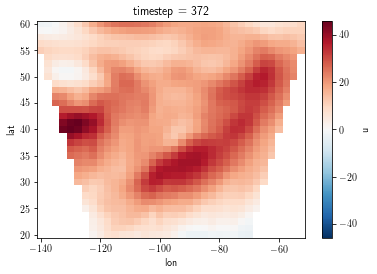

In [29]:
l = data['u'].isel(timestep=0).plot()

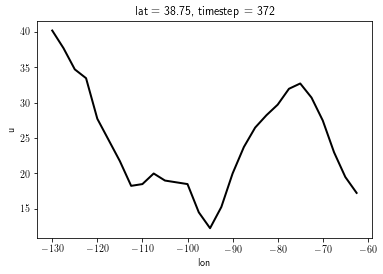

In [30]:
l = data['u'].isel(timestep=0, lat=15).plot()

## Mathematical operations

As for `pandas`, `xarray` comes with mathematical operations.

In [31]:
data = xr.open_mfdataset('data/*ISAS*', combine='by_coords')

To compute the mean over the entire dataset:

In [32]:
data.mean()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    TEMP     float32 dask.array<chunksize=(), meta=np.ndarray>

To compute the mean along time dimension:

In [33]:
data.mean(dim='time')

<xarray.Dataset>
Dimensions:  (depth: 152)
Coordinates:
  * depth    (depth) float32 0.0 3.0 5.0 10.0 ... 1.96e+03 1.98e+03 2e+03
Data variables:
    TEMP     (depth) float32 dask.array<chunksize=(152,), meta=np.ndarray>

Mean over the depth dimension:

In [34]:
data.mean(dim='depth')

<xarray.Dataset>
Dimensions:  (time: 4)
Coordinates:
  * time     (time) datetime64[ns] 2012-01-15 2012-02-15 2012-03-15 2012-04-15
Data variables:
    TEMP     (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>

**Contrary to `numpy` eager evaluations, `xarray` performs lazy operations.** As indicated on the `xarray` website:

```
Operations queue up a series of tasks mapped over blocks, and no computation is performed until you actually ask values to be computed (e.g., to print results to your screen or write to disk)
```

To force the computation, the `compute` and/or `load` methods must be used. Let's compare the outputs below:

In [35]:
data['TEMP'].mean(dim='time')

<xarray.DataArray 'TEMP' (depth: 152)>
dask.array<mean_agg-aggregate, shape=(152,), dtype=float32, chunksize=(152,), chunktype=numpy.ndarray>
Coordinates:
  * depth    (depth) float32 0.0 3.0 5.0 10.0 ... 1.96e+03 1.98e+03 2e+03

In [36]:
data['TEMP'].mean(dim='time').compute()

<xarray.DataArray 'TEMP' (depth: 152)>
array([28.292002 , 28.27325  , 28.25     , 28.232248 , 28.216    ,
       28.1895   , 28.14475  , 28.1115   , 28.089    , 28.061497 ,
       27.9785   , 27.86825  , 27.706749 , 27.5455   , 27.37575  ,
       27.187498 , 27.0145   , 26.845251 , 26.65725  , 26.47975  ,
       26.300251 , 26.0765   , 25.755249 , 25.4485   , 25.126    ,
       24.78375  , 24.461    , 24.11975  , 23.7695   , 23.343248 ,
       22.948502 , 22.54125  , 22.131    , 21.701248 , 21.247501 ,
       20.817501 , 20.380499 , 19.909    , 19.467499 , 19.02     ,
       18.53825  , 18.0675   , 17.5955   , 17.04475  , 16.568    ,
       16.05925  , 15.553499 , 15.09725  , 14.63025  , 14.14725  ,
       13.635249 , 13.13725  , 12.675499 , 12.21725  , 11.77075  ,
       11.3205   , 10.8885   , 10.518499 , 10.15325  ,  9.795    ,
        9.4395   ,  9.1145   ,  8.85225  ,  8.580999 ,  8.3245   ,
        8.07675  ,  7.8415   ,  7.63525  ,  7.43375  ,  7.23325  ,
        7.0390005,  6.8665   ,  6.71575  ,  6.5675   ,  6.43225  ,
        6.2975   ,  6.17     ,  6.0575   ,  5.9509997,  5.8425   ,
        5.7382503,  5.6480002,  5.5719995,  5.4975   ,  5.42175  ,
        5.34825  ,  5.27975  ,  5.21525  ,  5.1465   ,  5.07925  ,
        5.01725  ,  4.94625  ,  4.8315   ,  4.7165   ,  4.6045   ,
        4.4805   ,  4.36025  ,  4.2535   ,  4.1505   ,  4.0602503,
        3.9720001,  3.8920002,  3.81175  ,  3.738    ,  3.6685   ,
        3.59775  ,  3.53025  ,  3.4675   ,  3.409    ,  3.3554997,
        3.3115   ,  3.2615001,  3.2140002,  3.1664999,  3.12425  ,
        3.0805001,  3.038    ,  2.99825  ,  2.9597497,  2.92275  ,
        2.88575  ,  2.8477502,  2.81425  ,  2.7842498,  2.7525   ,
        2.72125  ,  2.69175  ,  2.66325  ,  2.63925  ,  2.61625  ,
        2.5945   ,  2.5705   ,  2.549    ,  2.527    ,  2.50675  ,
        2.4875   ,  2.46925  ,  2.4507499,  2.43275  ,  2.4145   ,
        2.39675  ,  2.3785   ,  2.3617501,  2.3445   ,  2.32725  ,
        2.3095002,  2.2925   ,  2.27625  ,  2.25875  ,  2.2437499,
        2.2265   ,  2.22025  ], dtype=float32)
Coordinates:
  * depth    (depth) float32 0.0 3.0 5.0 10.0 ... 1.96e+03 1.98e+03 2e+03

In the first output, no values are displayed. The `mean` has not been computed yet. In the second output, the effective mean values are shown because computation has been forced using `compute`.

## Group-by operations

The [groupby](http://xarray.pydata.org/en/stable/groupby.html) methods allows to easily perform operations on indepedent groups. For instance, to compute temporal (yearly, monthly, seasonal) means:

In [37]:
data.groupby('time.month').mean(dim='time')

<xarray.Dataset>
Dimensions:  (month: 4, depth: 152)
Coordinates:
  * depth    (depth) float32 0.0 3.0 5.0 10.0 ... 1.96e+03 1.98e+03 2e+03
  * month    (month) int64 1 2 3 4
Data variables:
    TEMP     (month, depth) float32 dask.array<chunksize=(1, 152), meta=np.ndarray>

In [38]:
data.groupby('time.year').mean(dim='time')

<xarray.Dataset>
Dimensions:  (year: 1, depth: 152)
Coordinates:
  * depth    (depth) float32 0.0 3.0 5.0 10.0 ... 1.96e+03 1.98e+03 2e+03
  * year     (year) int64 2012
Data variables:
    TEMP     (year, depth) float32 dask.array<chunksize=(1, 152), meta=np.ndarray>

In [39]:
data.groupby('time.season').mean(dim='time')

<xarray.Dataset>
Dimensions:  (season: 2, depth: 152)
Coordinates:
  * depth    (depth) float32 0.0 3.0 5.0 10.0 ... 1.96e+03 1.98e+03 2e+03
  * season   (season) object 'DJF' 'MAM'
Data variables:
    TEMP     (season, depth) float32 dask.array<chunksize=(1, 152), meta=np.ndarray>

Defining discrete binning (for depth intervals for instance) is done by using the 
[groupby_bins](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.groupby_bins.html#xarray.Dataset.groupby_bins) method.

In [40]:
depth_bins = np.arange(0, 1000 + 250, 250)
depth_bins

array([   0,  250,  500,  750, 1000])

In [41]:
zmean = data.groupby_bins('depth', depth_bins).mean(dim='depth')
zmean

<xarray.Dataset>
Dimensions:     (depth_bins: 4, time: 4)
Coordinates:
  * depth_bins  (depth_bins) object (0, 250] (250, 500] (500, 750] (750, 1000]
  * time        (time) datetime64[ns] 2012-01-15 2012-02-15 ... 2012-04-15
Data variables:
    TEMP        (depth_bins, time) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>

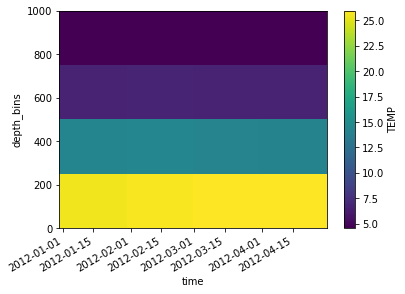

In [42]:
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False
cs = zmean['TEMP'].plot()

Let's reload the ISAS dataset

In [43]:
data = xr.open_mfdataset('data/*ISAS*', combine='by_coords').isel(time=0)
data

<xarray.Dataset>
Dimensions:  (depth: 152)
Coordinates:
  * depth    (depth) float32 0.0 3.0 5.0 10.0 ... 1.96e+03 1.98e+03 2e+03
    time     datetime64[ns] 2012-01-15
Data variables:
    TEMP     (depth) float32 dask.array<chunksize=(152,), meta=np.ndarray>
Attributes:
    script:   extract_prof.py
    history:  Thu Jul 14 11:32:10 2016: ncks -O -3 ISAS13_20120115_fld_TEMP.n...
    NCO:      "4.5.5"

There is the possibility to compute rolling means along the depth dimensions as follows:

In [44]:
datar = data.rolling({'depth': 31}, center=True).mean(dim='depth')
datar

<xarray.Dataset>
Dimensions:  (depth: 152)
Coordinates:
  * depth    (depth) float32 0.0 3.0 5.0 10.0 ... 1.96e+03 1.98e+03 2e+03
    time     datetime64[ns] 2012-01-15
Data variables:
    TEMP     (depth) float64 dask.array<chunksize=(151,), meta=np.ndarray>
Attributes:
    script:   extract_prof.py
    history:  Thu Jul 14 11:32:10 2016: ncks -O -3 ISAS13_20120115_fld_TEMP.n...
    NCO:      "4.5.5"

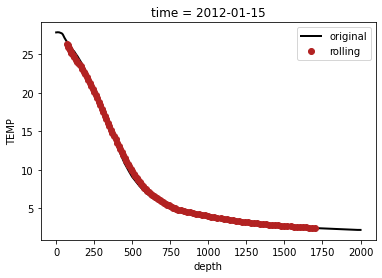

In [45]:
data['TEMP'].plot(label='original')
datar['TEMP'].plot(label='rolling', marker='o', linestyle='none')
plt.legend()

## Creating NetCDF

An easy way to write a NetCDF is to create a `DataSet` object. First, let'sdefine some dummy variables:

In [46]:
import numpy as np
import cftime

nx = 10
ny = 20
ntime = 5
x = np.arange(nx)
y = np.arange(ny)

data = np.random.rand(ntime, ny, nx) - 0.5
data = np.ma.masked_where(data < 0, data)

# converts time into date
time = np.arange(ntime)
date = cftime.num2date(time, 'days since 1900-01-01 00:00:00')

In [47]:
date

array([cftime.DatetimeGregorian(1900, 1, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(1900, 1, 2, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(1900, 1, 3, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(1900, 1, 4, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(1900, 1, 5, 0, 0, 0, 0, has_year_zero=False)],
      dtype=object)

In [48]:
data.shape

(5, 20, 10)

First, init an empty `Dataset` object by calling the [xarray.Dataset](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.html) method.

In [49]:
ds = xr.Dataset()

Then, add to the dataset the variables and coordinates. Note that they should be provided as a tuple that contains two elements:
- A list of dimension names
- The numpy array

In [50]:
ds['data'] = (['time', 'y', 'x'], data)
ds['x'] = (['x'], x)
ds['y'] = (['y'], y)
ds['time'] = (['time'], date)
ds

<xarray.Dataset>
Dimensions:  (time: 5, y: 20, x: 10)
Coordinates:
  * x        (x) int64 0 1 2 3 4 5 6 7 8 9
  * y        (y) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
  * time     (time) object 1900-01-01 00:00:00 ... 1900-01-05 00:00:00
Data variables:
    data     (time, y, x) float64 nan nan nan 0.1934 ... 0.07791 0.2112 nan nan

Then, add global and variable attributes to the dataset as follows:

In [51]:
import os
from datetime import datetime

# Set file global attributes (file directory name + date)
ds.attrs['script'] = os.getcwd()
ds.attrs['date'] = str(datetime.today())

ds['data'].attrs['description'] = 'Random draft'
ds

<xarray.Dataset>
Dimensions:  (time: 5, y: 20, x: 10)
Coordinates:
  * x        (x) int64 0 1 2 3 4 5 6 7 8 9
  * y        (y) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
  * time     (time) object 1900-01-01 00:00:00 ... 1900-01-05 00:00:00
Data variables:
    data     (time, y, x) float64 nan nan nan 0.1934 ... 0.07791 0.2112 nan nan
Attributes:
    script:   /home/barrier/Work/scientific_communication/seminaires_pomm/pyt...
    date:     2021-10-21 16:12:37.555231

Finally, create the NetCDF file by using the [to_netcdf](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.to_netcdf.html) method.

In [52]:
ds.to_netcdf('data/example.nc', unlimited_dims='time', format='NETCDF4')

Note that xarray automatically writes the `_FillValue` attribute and the `time:units` attributes.